In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Get the data, models and predictions

In [4]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [5]:
# Data Transformation
mode_simulation_data = {
    'SS1': pd.DataFrame(),
    'FA1': pd.DataFrame(),
    'SS2': pd.DataFrame(),
    'FA2': pd.DataFrame(),
}
for key in simulation_data.keys():
    if 'Eigen_' in key:
        simulation_data[key].rename(
            columns={
                '1st SS': 'SS1',
                '1st FA': 'FA1',
                '2nd SS': 'SS2',
                '2nd FA': 'FA2',
            }, inplace=True
        )
        for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
            mode_simulation_data[mode][key] = simulation_data[key][mode]

# order the columns
cols = list(simulation_data.keys())
ordered_cols = [cols[0]] + cols[9:11] + cols[1:9] + [cols[11]] + cols[20:22] + cols[12:20]
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    mode_simulation_data[mode] = mode_simulation_data[mode][ordered_cols]
    mode_simulation_data[mode].to_csv(simulations_data_path + "mode_frequencies/" + mode + ".csv")

tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

In [6]:
import mlflow
models = {}
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'
    try:
        models[mode] = \
            mlflow.pyfunc.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [7]:
weather_inputs = get_weather_subset(mvbc_data)
scada_inputs = get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [8]:
predictions = pd.DataFrame(index = inputs.dropna().index)
for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
residuals = prediction_params - predictions
normalized = residuals + tracked_frequencies.mean()

## Power analysis for the different modal frequencies and scouring scenarios
Power analysis determines the number of samples to consider

In [23]:
from statsmodels.stats.power import Power
from statsmodels.stats.power import TTestIndPower,TTestPower
from matplotlib import pyplot as plt
import numpy as np
power = 0.99
significance = 0.01
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
modes = ['SS1', 'SS2', 'FA1', 'FA2']

In [14]:
# No normalization
normal_population_data = tracked_frequencies
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  4440.008518359691 , in days:  30.83
0.1D  nr of samples:  285.07932908807265 , in days:  1.98
0.2D  nr of samples:  141.8542667602522 , in days:  0.99
0.3D  nr of samples:  58.06053551695049 , in days:  0.4
0.4D  nr of samples:  28.326328566490133 , in days:  0.2
SS2
0.05D  nr of samples:  798.4315833499217 , in days:  5.54
0.1D  nr of samples:  54.37422582537139 , in days:  0.38
0.2D  nr of samples:  28.183875333498964 , in days:  0.2
0.3D  nr of samples:  12.591908278620204 , in days:  0.09
0.4D  nr of samples:  7.070749092619846 , in days:  0.05
FA1
0.05D  nr of samples:  24337.881722683564 , in days:  169.01
0.1D  nr of samples:  1556.0665029626773 , in days:  10.81
0.2D  nr of samples:  770.6085352508562 , in days:  5.35
0.3D  nr of samples:  310.94273607305837 , in days:  2.16
0.4D  nr of samples:  147.6694833274242 , in days:  1.03
FA2
0.05D  nr of samples:  460.69643432393997 , in days:  3.2
0.1D  nr of samples:  32.33064262366473 , in days:  0.22
0.2

In [15]:
# With normalization
normal_population_data = normalized
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  2629.361778093529 , in days:  18.26
0.1D  nr of samples:  169.46328237759195 , in days:  1.18
0.2D  nr of samples:  84.67443283750369 , in days:  0.59
0.3D  nr of samples:  35.084028791525796 , in days:  0.24
0.4D  nr of samples:  17.51263255913455 , in days:  0.12
SS2
0.05D  nr of samples:  172.65874917584162 , in days:  1.2
0.1D  nr of samples:  13.102588406645799 , in days:  0.09
0.2D  nr of samples:  7.574631120070531 , in days:  0.05
0.3D  nr of samples:  4.357189002114248 , in days:  0.03
0.4D  nr of samples:  3.2088707532883998 , in days:  0.02
FA1
0.05D  nr of samples:  9179.01313331245 , in days:  63.74
0.1D  nr of samples:  587.8390072567304 , in days:  4.08
0.2D  nr of samples:  291.64013411432967 , in days:  2.03
0.3D  nr of samples:  118.30473271101552 , in days:  0.82
0.4D  nr of samples:  56.747317971553244 , in days:  0.39
FA2
0.05D  nr of samples:  128.48331556495287 , in days:  0.89
0.1D  nr of samples:  10.292341051382692 , in days:  0.07
0

In [26]:
# With normalization

normal_population_data = normalized
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  1317.1715260156782 , in days:  9.15
0.1D  nr of samples:  87.2571125981997 , in days:  0.61
0.2D  nr of samples:  44.89595568204568 , in days:  0.31
0.3D  nr of samples:  20.17332970083981 , in days:  0.14
0.4D  nr of samples:  11.450986015222695 , in days:  0.08
SS2
0.05D  nr of samples:  88.85419095749168 , in days:  0.62
0.1D  nr of samples:  9.256800633014 , in days:  0.06
0.2D  nr of samples:  6.4403935871830615 , in days:  0.04
0.3D  nr of samples:  4.604390193838766 , in days:  0.03
0.4D  nr of samples:  3.788868536663863 , in days:  0.03
FA1
0.05D  nr of samples:  4591.995394645047 , in days:  31.89
0.1D  nr of samples:  296.4188179130947 , in days:  2.06
0.2D  nr of samples:  148.3304146399079 , in days:  1.03
0.3D  nr of samples:  61.6927148359784 , in days:  0.43
0.4D  nr of samples:  30.961139757025 , in days:  0.22
FA2
0.05D  nr of samples:  66.77817763554351 , in days:  0.46
0.1D  nr of samples:  7.843625866994616 , in days:  0.05
0.2D  nr of sa

In [ ]:
def mann_withney_u_power_analysis(normal_data, shifted_data, alpha, power):
    """
    Calculate the required sample size for a Mann-Whitney U test with given
    effect size, alpha, and power.
    """

In [16]:
from scipy.stats import mannwhitneyu, norm
import numpy as np

def MWUPower(noraml_data, shifted_data, alpha=0.05, power=0.8, alternative='two-sided'):
    """
    Calculate the required sample size for a Mann-Whitney U test with given
    effect size, alpha, and power.
    """
    # calculate the effect size
    delta = (np.median(noraml_data) - np.median(shifted_data))/ noraml_data.std()

    
    z_alpha = norm.ppf(1 - (alpha/2))
    u_alpha = mannwhitneyu(noraml_data, shifted_data, alternative='two-sided')[1]
    
    # calculate the power for the given sample size
    power_m = 1 - norm.cdf((z_alpha - np.sqrt(m) * delta - u_alpha) / np.sqrt(1 + m / n1 + m / n2))
    
    # increase sample size until desired power is reached
    while power_m < power:
        m += 1
        power_m = 1 - norm.cdf((z_alpha - np.sqrt(m) * delta - u_alpha) / np.sqrt(1 + m / n1 + m / n2))
    
    n1_star = round(m / (1 + (n2 / n1)))
    n2_star = round(m / (1 + (n1 / n2)))
    
    return n1_star, n2_star

In [18]:
# With normalization
normal_population_data = normalized
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))
        print(len(normal_population), len(scour_population), MWUPower(len(normal_population), len(scour_population), effect_size, alpha=significance, power=power, alternative='two-sided'))

SS1
0.05D  nr of samples:  2629.361778093529 , in days:  18.26
17281 17281 (4320, 4320)
0.1D  nr of samples:  169.46328237759195 , in days:  1.18
17281 17281 (4320, 4320)
0.2D  nr of samples:  84.67443283750369 , in days:  0.59
17281 17281 (4320, 4320)
0.3D  nr of samples:  35.084028791525796 , in days:  0.24
17281 17281 (4320, 4320)
0.4D  nr of samples:  17.51263255913455 , in days:  0.12
17281 17281 (4320, 4320)
SS2
0.05D  nr of samples:  172.65874917584162 , in days:  1.2
17281 17281 (4320, 4320)
0.1D  nr of samples:  13.102588406645799 , in days:  0.09
17281 17281 (4320, 4320)
0.2D  nr of samples:  7.574631120070531 , in days:  0.05
17281 17281 (4320, 4320)
0.3D  nr of samples:  4.357189002114248 , in days:  0.03
17281 17281 (4320, 4320)
0.4D  nr of samples:  3.2088707532883998 , in days:  0.02
17281 17281 (4320, 4320)
FA1
0.05D  nr of samples:  9179.01313331245 , in days:  63.74
17281 17281 (4320, 4320)
0.1D  nr of samples:  587.8390072567304 , in days:  4.08
17281 17281 (4320, 43

C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:47: RuntimeWarning: overflow encountered in long_scalars
  var_mw = n1 * n2 * (n1 + n2 + 1) / 12
C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:50: RuntimeWarning: invalid value encountered in sqrt
  lambda_mw = (U - mu_mw) / np.sqrt(var_mw)
C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:53: RuntimeWarning: invalid value encountered in sqrt
  u_alpha = mu_mw + z_alpha * np.sqrt(var_mw) + z_beta * np.sqrt(var_mw / n2)
C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:56: RuntimeWarning: invalid value encountered in sqrt
  power_m = 1 - norm.cdf((u_alpha - mu_mw - lambda_mw * np.sqrt(var_mw)) / np.sqrt(var_mw))


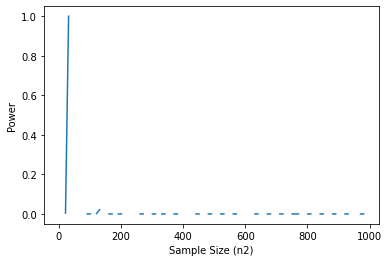

In [21]:
import numpy as np
from scipy.stats import mannwhitneyu

# Define effect size (mean difference between two groups)
delta = 0.5

# Set significance level and desired power
alpha = 0.05
power = 0.8

mode = 'SS1'
scouring_scenario = '0.05D'

normal_population_data = normalized
x1 = normal_population_data[mode]
x2 = normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )
# Set sample size of the first dataset (x1)
n1 = len(x1)

# Set range of sample sizes for the second dataset (x2)
n2_range = np.arange(1, 1000, 10)

# effect_size
delta = (x1.mean() - x2.mean())/x1.std()

# Define function to calculate power for different sample sizes
def calculate_power(n1, n2, delta, alpha, power):
    # Generate two datasets with the given sample sizes and effect size
    x1 = np.random.normal(loc=0, scale=1, size=n1)
    x2 = np.random.normal(loc=delta, scale=1, size=n2)
    
    # Calculate the Mann-Whitney U test statistic and p-value
    U, p_value = mannwhitneyu(x1, x2, alternative='two-sided')
    
    # Calculate the critical value for rejecting the null hypothesis
    z_alpha = norm.ppf(1 - alpha/2)
    
    # Calculate the critical value for accepting the alternative hypothesis
    z_beta = norm.ppf(power)
    
    # Calculate the mean and standard deviation of the Mann-Whitney U distribution
    mu_mw = n1 * n2 / 2
    var_mw = n1 * n2 * (n1 + n2 + 1) / 12
    
    # Calculate the non-centrality parameter lambda
    lambda_mw = (U - mu_mw) / np.sqrt(var_mw)
    
    # Calculate the critical value for rejecting the null hypothesis based on the given power
    u_alpha = mu_mw + z_alpha * np.sqrt(var_mw) + z_beta * np.sqrt(var_mw / n2)
    
    # Calculate the power for the given sample sizes
    power_m = 1 - norm.cdf((u_alpha - mu_mw - lambda_mw * np.sqrt(var_mw)) / np.sqrt(var_mw))
    
    return power_m

# Calculate power for each sample size in n2_range
power_values = []
for n2 in n2_range:
    power_values.append(calculate_power(n1, n2, delta, alpha, power))

# Plot power as a function of sample size n2
import matplotlib.pyplot as plt

plt.plot(n2_range, power_values)
plt.xlabel('Sample Size (n2)')
plt.ylabel('Power')
plt.show()
